In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
from sklearn.metrics import mean_absolute_error

In [83]:
from darts import TimeSeries
from darts.models import AutoARIMA, LightGBMModel

In [84]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set(font_scale=1.25)

In [3]:
data = pd.read_csv("train.csv")

In [4]:
train = pd.DataFrame()
train["Unit"] = data["БЕ"]
train["Date"] = data["Дата транзакции"]
train["RUB"] = data["Сумма в RUB"]

In [5]:
train_0 = train[train["Unit"]==0][["Date", "RUB"]]
train_0.set_index(pd.to_datetime(train_0["Date"]), inplace=True)
train_0.drop(["Date"], inplace=True, axis=1)

train_1 = train[train["Unit"]==1][["Date", "RUB"]]
train_1.set_index(pd.to_datetime(train_1["Date"]), inplace=True)
train_1.drop(["Date"], inplace=True, axis=1)

train_2 = train[train["Unit"]==2][["Date", "RUB"]]
train_2.set_index(pd.to_datetime(train_2["Date"]), inplace=True)
train_2.drop(["Date"], inplace=True, axis=1)

train_3 = train[train["Unit"]==3][["Date", "RUB"]]
train_3.set_index(pd.to_datetime(train_3["Date"]), inplace=True)
train_3.drop(["Date"], inplace=True, axis=1)

train_4 = train[train["Unit"]==4][["Date", "RUB"]]
train_4.set_index(pd.to_datetime(train_4["Date"]), inplace=True)
train_4.drop(["Date"], inplace=True, axis=1)

train_5 = train[train["Unit"]==5][["Date", "RUB"]]
train_5.set_index(pd.to_datetime(train_5["Date"]), inplace=True)
train_5.drop(["Date"], inplace=True, axis=1)

train_6 = train[train["Unit"]==6][["Date", "RUB"]]
train_6.set_index(pd.to_datetime(train_6["Date"]), inplace=True)
train_6.drop(["Date"], inplace=True, axis=1)

In [6]:
train_5_1d = train_5.resample('1D').sum()

<AxesSubplot:xlabel='Date'>

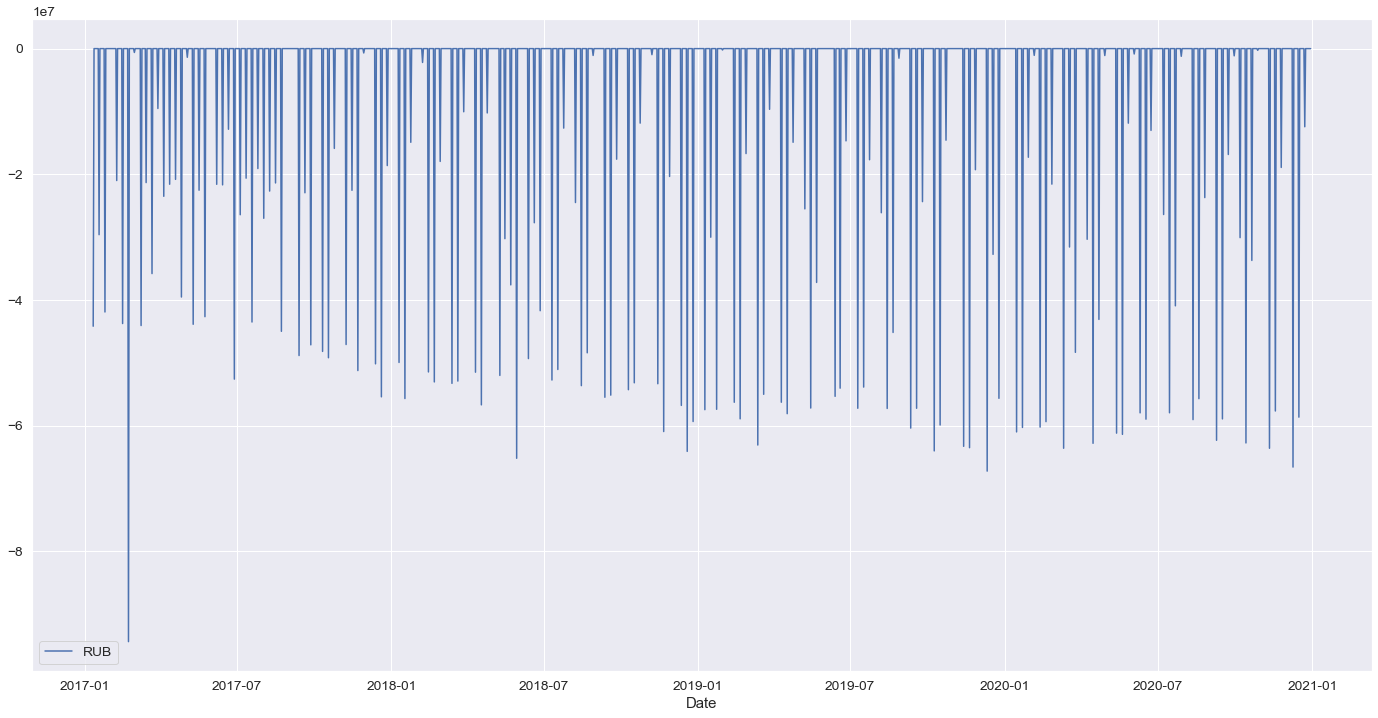

In [7]:
sns.lineplot(data=train_5_1d)

In [31]:
# Первая дата - 2017-01-11, нужно знать для обрезки доп. датасета contractor
train_5_1d.iloc[0]

RUB   -4.416300e+07
Name: 2017-01-11 00:00:00, dtype: float64

In [12]:
# файл, содержащий информацию об контрагентах в разрезе БЕ №5

# Сумма документа - Сумма в документе оплаты в периоде
# % оплаты - Оплата в процентном соотношении
# Сумма оплачено - Оплата в денежном выражении
# Сумма оплачено с НДС - Оплата в денежном выражении с учетом НДС
# Дата документа - Дата выпуска счета на оплату
# Дата закрытия аванса - Дата проведения оплаты
# Дата постановки на оплату - Дата включения в календарь платежей Северстали
# Контрагент - № контрагента

data = pd.read_csv("Контрагенты по годам.csv")

In [13]:
# Чистка, подгонка

data.replace(to_replace={"17.02.1016":"2016-02-17 00:00:00"}, inplace=True)
data.replace(to_replace={"31.06.2016":"2016-05-31 00:00:00", "31.11.2016":"2016-10-31 00:00:00", "31.06.2017":"2017-05-31 00:00:00"}, inplace=True)
#"31.06.2016":"2016-06-30 00:00:00", изменен день
#"31.11.2016":"2016-11-30 00:00:00", изменен день
#"31.06.2017":"2017-06-30 00:00:00" изменен день
data.replace({"-95711.4357159999": np.nan, "90241.6106160001": np.nan, "без оплаты": np.nan, "переплата!!": np.nan}, inplace=True) 

# data["дата докум.3"]
# 31.06.2016
# 31.11.2016
# 31.06.2017

# data["Дата постановки на оплату (оконч. платеж.)"]
# -95711.4357159999
# 90241.6106160001
# без оплаты
# переплата!!
# 37 строка "сумма к оплате с учетом аванса,с НДС" - неправильное значение (29278.912708, а должно быть отрицательное)

In [14]:
# legacy
#sns.lineplot(x=train_5.index, y=train_5["RUB"])
#(pd.to_datetime(data["Дата транзакции"]).dt.date - pd.to_datetime(data["Дата транзакции"]).dt.date.shift(1)).value_counts() #циклично

In [15]:
contractor = pd.DataFrame()

contractor["Doc_date_op"] = pd.to_datetime(pd.to_datetime(data["дата докум."]).dt.date)
contractor["Doc_date_op"].fillna(pd.NaT, inplace=True)
contractor["Date_reg_prepay"] = pd.to_datetime(pd.to_datetime(data["Дата постановки на оплату (аванс)"]).dt.date)
contractor["Date_reg_prepay"].fillna(pd.NaT, inplace=True)
contractor["Doc_date_cl"] = pd.to_datetime(pd.to_datetime(data["дата докум.3"]).dt.date)
contractor["Doc_date_cl"].fillna(pd.NaT, inplace=True)
contractor["Date_prepay_cl"] = pd.to_datetime(pd.to_datetime(data["Дата закр. Аванса"]).dt.date)
contractor["Date_prepay_cl"].fillna(pd.NaT, inplace=True)
contractor["Date_reg_fin"] =  pd.to_datetime(pd.to_datetime(data["Дата постановки на оплату (оконч. платеж.)"]).dt.date)
contractor["Date_reg_fin"].fillna(pd.NaT, inplace=True)

contractor["Sum_doc_wo_VAT"] = data["сумма док.,без НДС"] # ???
contractor["Ratio"] = data["% оплаты"]
contractor["Sum_doc_wo_VAT2"] = data["сумма док.,без НДС2"]
contractor["Sum_paid_wo_VAT"] = data["сумма оплачено,без НДС"]
contractor["Sum_to_pay_with_prepay_wo_VAT"] = data["сумма к оплате с учетом аванса,без НДС"]

contractor["Sum_doc_VAT"] = data["сумма док.,с НДС"]
contractor["Sum_paid_VAT"] = data["сумма оплачено,с НДС "]
contractor["Sum_to_pay_with_prepay_VAT"] = data["сумма к оплате с учетом аванса,с НДС "]

contractor["Contractor"] = data["Контрагент"].astype(np.int8)




In [ ]:
# Ипользуем следущие данные: 
# Дата
# Дата постановки на оплату(Аванс) 
# И
# Дата постановки на оплату (оконч. платеж.)
# (Аванс)
# Сумма оплачено с НДС
# (Счет фактура)
# сумма к оплате с учетом аванса,с НДС : Разница между сумма док.с НДС  и сумма оплачено с НДС (сколько будет оплачено)

In [16]:
# Какой-то мусор в последней строке
contractor.drop(index=479, inplace=True) 

In [ ]:
# Проверяем даты на nan значения

In [17]:
contractor[contractor["Date_reg_prepay"].isna()]

,Doc_date_op,Date_reg_prepay,Doc_date_cl,Date_prepay_cl,Date_reg_fin,Sum_doc_wo_VAT,Ratio,Sum_doc_wo_VAT2,Sum_paid_wo_VAT,Sum_to_pay_with_prepay_wo_VAT,Sum_doc_VAT,Sum_paid_VAT,Sum_to_pay_with_prepay_VAT,Contractor
228,NaT,NaT,2018-01-31,NaT,2018-02-07,0.000000e+00,100.0,1.210750e+06,0.000000e+00,1.210750e+06,1.428685e+06,0.000000e+00,1.428685e+06,5
414,2020-04-10,NaT,NaT,2020-05-31,NaT,0.000000e+00,100.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3
426,NaT,NaT,2020-07-31,NaT,2020-08-26,1.409236e+06,100.0,2.518953e+06,1.409236e+06,1.109717e+06,3.022743e+06,1.691083e+06,1.331660e+06,3


In [18]:
contractor[contractor["Date_reg_fin"].isna()]

,Doc_date_op,Date_reg_prepay,Doc_date_cl,Date_prepay_cl,Date_reg_fin,Sum_doc_wo_VAT,Ratio,Sum_doc_wo_VAT2,Sum_paid_wo_VAT,Sum_to_pay_with_prepay_wo_VAT,Sum_doc_VAT,Sum_paid_VAT,Sum_to_pay_with_prepay_VAT,Contractor
4,2015-01-12,2015-01-13,2015-01-31,2015-02-26,NaT,1.638478e+07,100.0,4.785992e+07,1.638478e+07,1.509036e+07,5.647471e+07,1.933405e+07,1.780662e+07,4
10,2015-02-02,2015-02-04,2015-02-28,2015-03-25,NaT,1.565971e+07,100.0,4.571649e+07,1.565971e+07,1.439707e+07,5.394546e+07,1.847846e+07,1.698854e+07,4
16,2015-03-02,2015-03-11,2015-03-31,2015-04-29,NaT,1.696853e+07,100.0,4.472842e+07,1.696853e+07,1.079136e+07,5.277954e+07,2.002287e+07,1.273381e+07,4
22,2015-04-01,2015-04-08,2015-04-30,2015-05-27,NaT,1.630000e+07,100.0,4.603926e+07,1.630000e+07,1.343926e+07,5.432633e+07,1.923400e+07,1.585833e+07,4
24,2015-05-10,2015-05-20,2015-05-31,2015-06-24,NaT,8.044423e+05,70.0,2.161190e+06,1.823364e+06,3.378260e+05,2.550205e+06,2.151570e+06,3.986347e+05,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,2021-02-25,2021-03-10,NaT,2021-04-30,NaT,1.572466e+06,50.0,0.000000e+00,7.862332e+05,-7.862332e+05,0.000000e+00,9.434799e+05,-9.434799e+05,1
475,2021-02-19,2021-03-10,NaT,2021-04-30,NaT,4.076424e+07,50.0,0.000000e+00,2.038212e+07,-2.038212e+07,0.000000e+00,2.445854e+07,-2.445854e+07,2
476,2021-02-19,2021-03-10,NaT,2021-04-30,NaT,9.121529e+06,50.0,0.000000e+00,4.560764e+06,-4.560764e+06,0.000000e+00,5.472917e+06,-5.472917e+06,2
477,2021-02-25,2021-03-10,NaT,2021-03-31,NaT,2.586886e+07,100.0,0.000000e+00,2.586886e+07,-5.173772e+07,0.000000e+00,3.104263e+07,-6.208527e+07,4


In [19]:
contractor_fixed = contractor.copy(deep=True)

In [20]:
# Здесь и далее замены "фейковые", только для сходимости временного ряда

In [21]:
# Замена отсутствующих значений
contractor_fixed["Date_reg_prepay"].fillna(contractor_fixed["Date_reg_fin"], inplace=True)

In [22]:
contractor_fixed[contractor_fixed["Date_reg_prepay"].isna()]

,Doc_date_op,Date_reg_prepay,Doc_date_cl,Date_prepay_cl,Date_reg_fin,Sum_doc_wo_VAT,Ratio,Sum_doc_wo_VAT2,Sum_paid_wo_VAT,Sum_to_pay_with_prepay_wo_VAT,Sum_doc_VAT,Sum_paid_VAT,Sum_to_pay_with_prepay_VAT,Contractor
414,2020-04-10,NaT,NaT,2020-05-31,NaT,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [23]:
# Пустышка (транзакция на 0 рублей)
contractor_fixed.drop(index=414, inplace=True)

In [24]:
# Замена отсутствующих значений
contractor_fixed["Date_reg_fin"].fillna(contractor_fixed["Date_prepay_cl"], inplace=True)

In [25]:
# Одно значение заменяем из другой колонки
contractor_fixed["Date_reg_fin"].fillna(contractor_fixed["Doc_date_cl"], inplace=True)

In [26]:
# Проверка
contractor_fixed[contractor_fixed["Date_reg_fin"].isna()]

,Doc_date_op,Date_reg_prepay,Doc_date_cl,Date_prepay_cl,Date_reg_fin,Sum_doc_wo_VAT,Ratio,Sum_doc_wo_VAT2,Sum_paid_wo_VAT,Sum_to_pay_with_prepay_wo_VAT,Sum_doc_VAT,Sum_paid_VAT,Sum_to_pay_with_prepay_VAT,Contractor


In [34]:
# Выделяем необходимые данные
contractor_fixed_prepay = contractor_fixed[(contractor_fixed["Date_reg_prepay"].dt.year<2021) & (contractor_fixed["Date_reg_prepay"].dt.date>=pd.to_datetime("2017-01-11"))][["Date_reg_prepay", "Sum_paid_VAT"]]
contractor_fixed_prepay.set_index("Date_reg_prepay", inplace=True)

D:\Anaconda\envs\Python3712forTS\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [39]:
# Суммируем платежи внутри одного дня, без учета контрагента (такое же действие, как с БЕ №0)
contractor_fixed_prepay = contractor_fixed_prepay.groupby(contractor_fixed_prepay.index).sum()

<AxesSubplot:xlabel='Date_reg_prepay'>

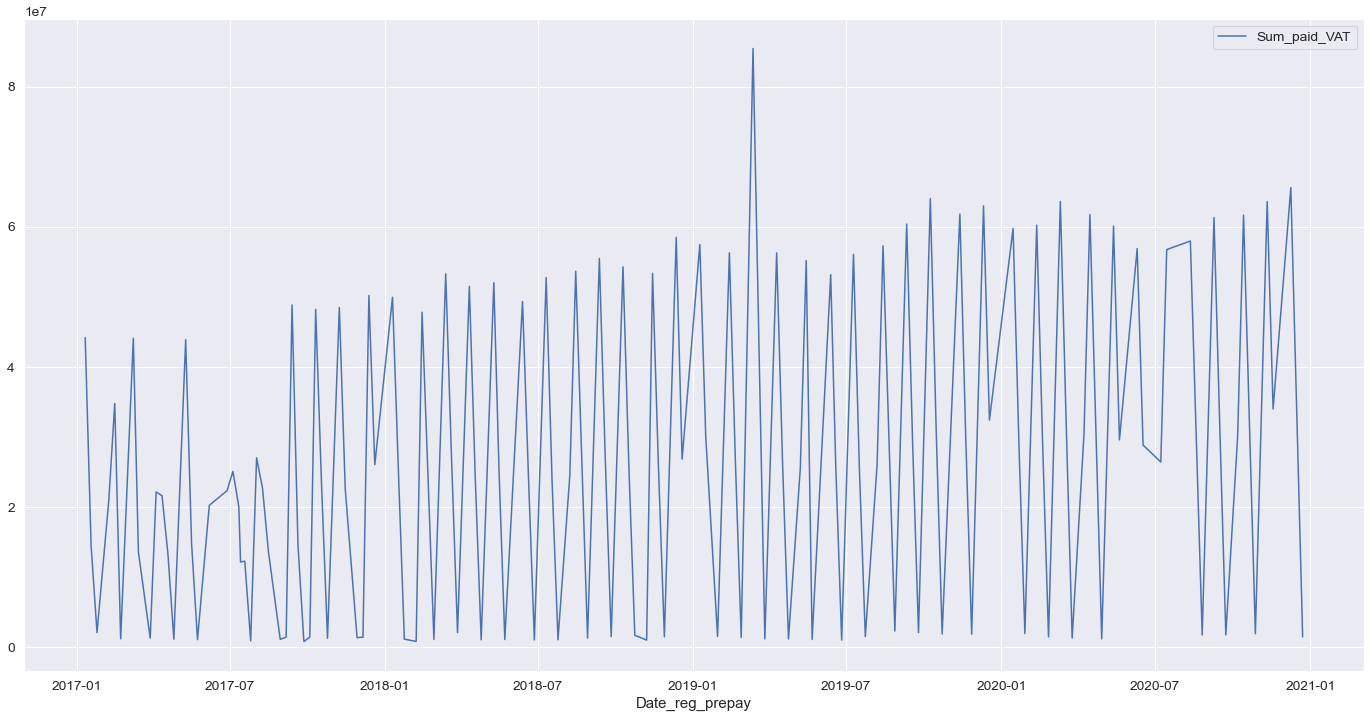

In [41]:
sns.lineplot(data=contractor_fixed_prepay)

In [42]:
contractor_fixed_pay = contractor_fixed[
    (contractor_fixed["Date_reg_fin"].dt.year < 2021)
    & (contractor_fixed["Date_reg_fin"].dt.date >= pd.to_datetime("2017-01-11"))
][["Date_reg_fin", "Sum_to_pay_with_prepay_VAT"]]

D:\Anaconda\envs\Python3712forTS\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [44]:
contractor_fixed_pay.set_index("Date_reg_fin", inplace=True)

In [45]:
contractor_fixed_pay = contractor_fixed_pay.groupby(contractor_fixed_pay.index).sum()

<AxesSubplot:xlabel='Date_reg_fin'>

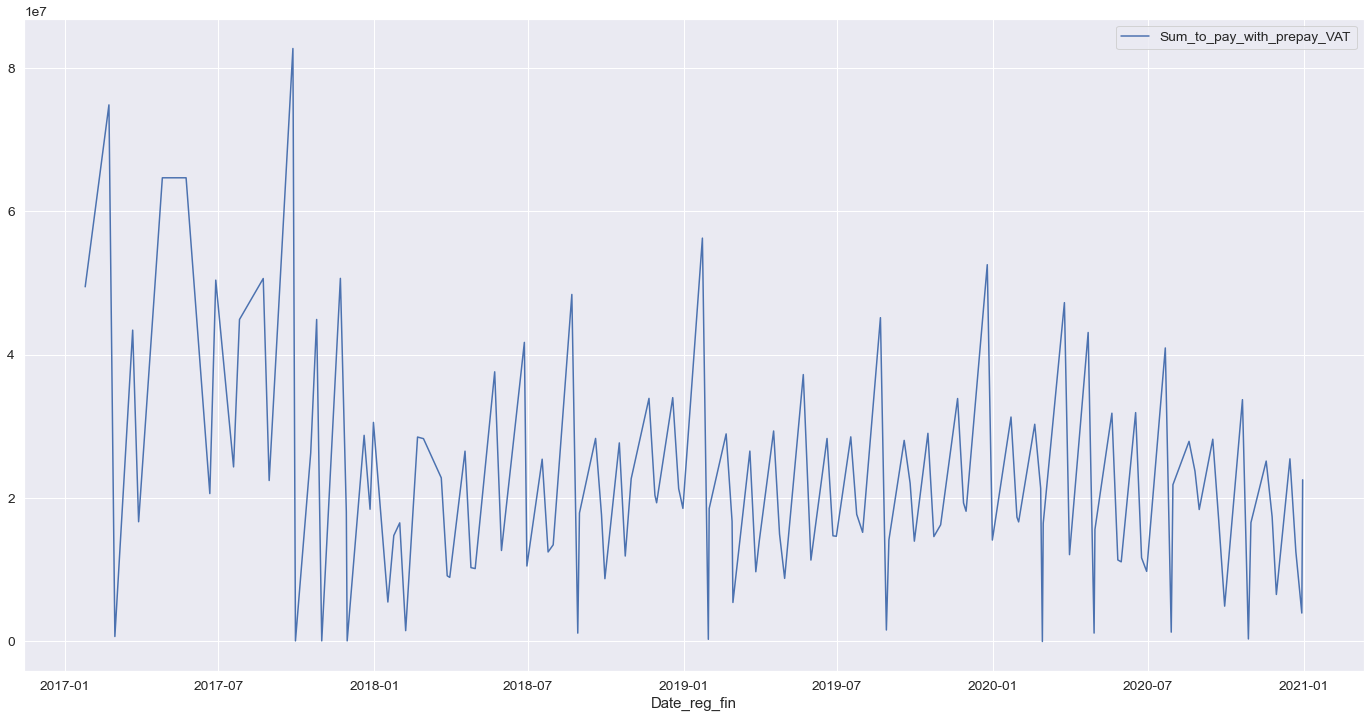

In [46]:
sns.lineplot(data=contractor_fixed_pay)

In [49]:
# Теперь аналогично, что и train данными
contractor_fixed_prepay_1d = contractor_fixed_prepay.resample('1D').sum()

In [52]:
contractor_fixed_pay_1d = contractor_fixed_pay.resample('1D').sum()

<AxesSubplot:xlabel='Date_reg_prepay'>

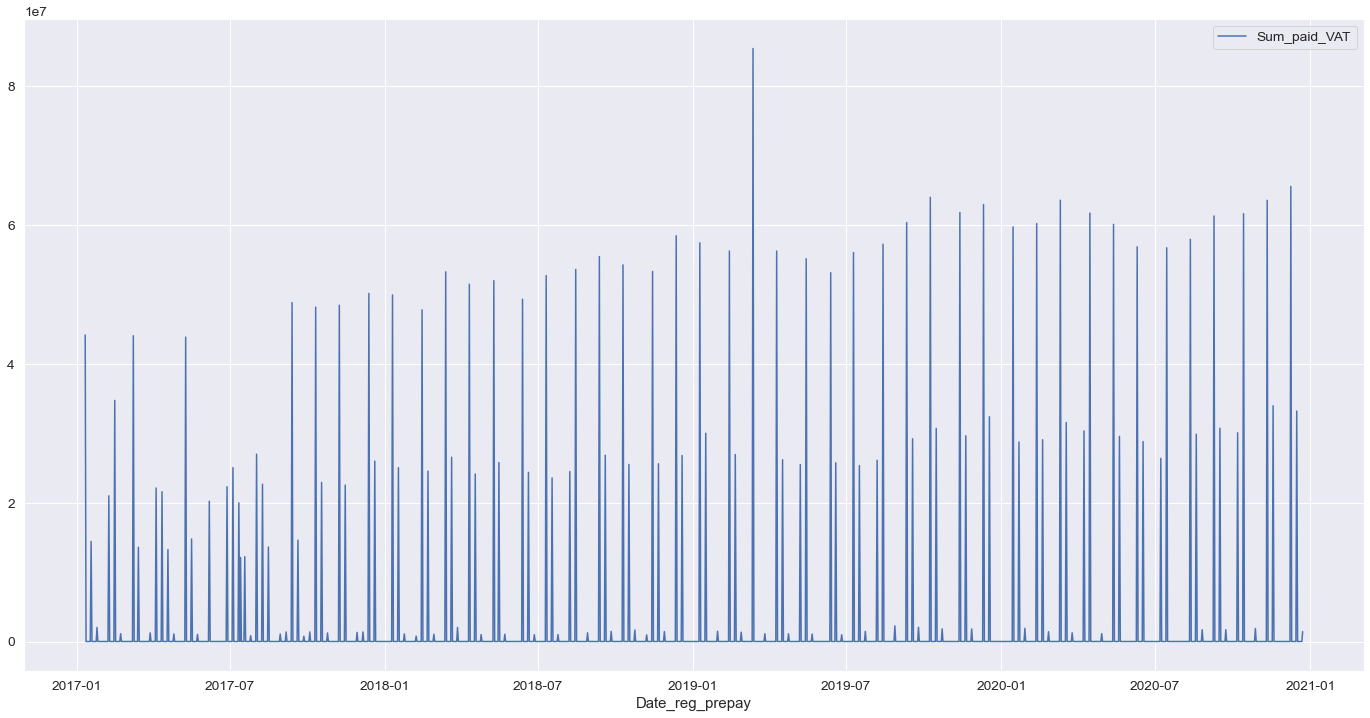

In [55]:
# Хорошо просматривается паттерн
sns.lineplot(data=contractor_fixed_prepay_1d)

<AxesSubplot:xlabel='Date_reg_fin'>

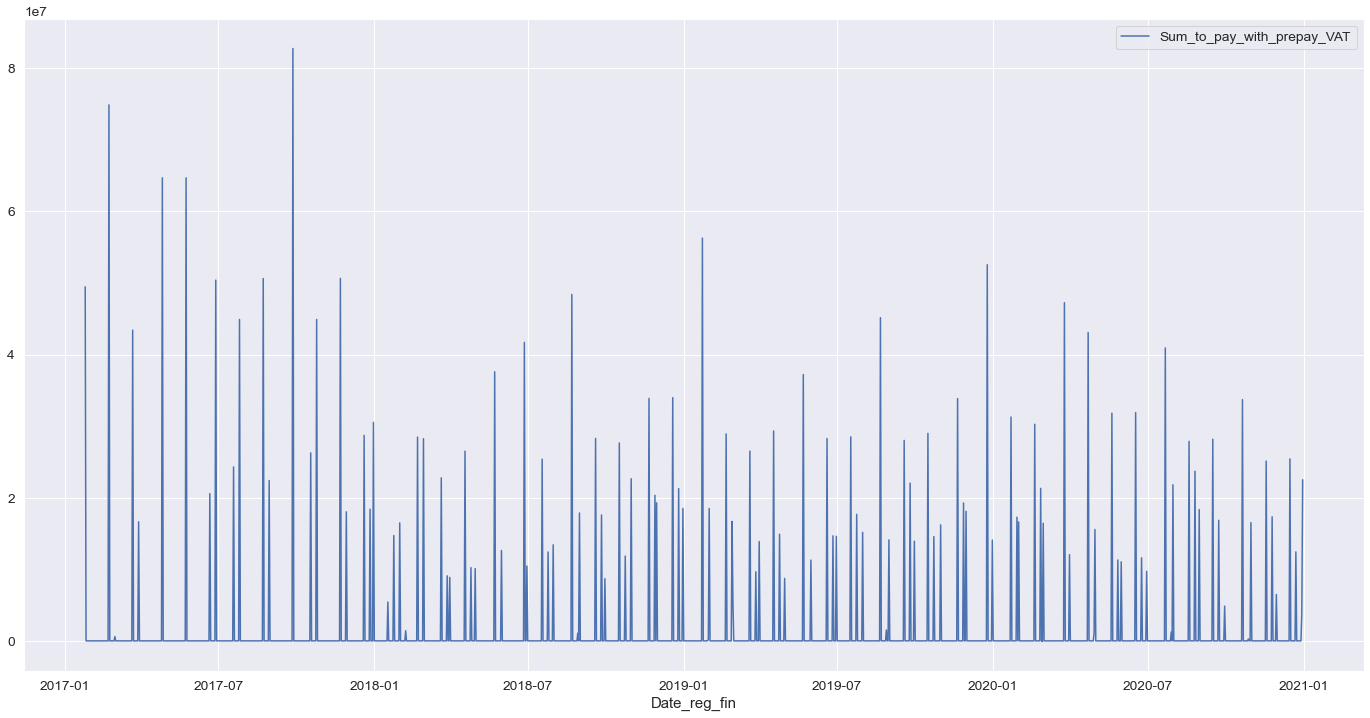

In [56]:
# Здесь паттерин просматривается, но не так четко
sns.lineplot(data=contractor_fixed_pay_1d)

In [ ]:
# Собираем временные ряды вместе

In [65]:
train_5_1d_addition = pd.merge(train_5_1d, contractor_fixed_prepay_1d, how='outer', left_on=train_5_1d.index, right_on=contractor_fixed_prepay_1d.index).fillna(0)

In [67]:
train_5_1d_addition.set_index("key_0", inplace=True)

In [70]:
train_5_1d_addition_2 = pd.merge(train_5_1d_addition, contractor_fixed_pay_1d, how='outer', left_on=train_5_1d_addition.index, right_on=contractor_fixed_pay_1d.index).fillna(0)

In [ ]:
train_5_1d_addition_2.set_index("key_0", inplace=True)

In [80]:
train_5_1d_reindex = train_5_1d_addition_2.reset_index()

In [88]:
# Перевод в формат, понятный darts
series_1d = TimeSeries.from_dataframe(train_5_1d_reindex, time_col='key_0', value_cols='RUB', freq='1d', fill_missing_dates=True)

In [96]:
# Трейн/валид для временного ряда
train_1d_split, val_1d_split = series_1d.split_before(0.80)

In [92]:
series_1d_pastcov1 = TimeSeries.from_dataframe(train_5_1d_reindex, time_col='key_0', value_cols='Sum_paid_VAT', freq='1d', fill_missing_dates=True)

In [93]:
series_1d_pastcov2 = TimeSeries.from_dataframe(train_5_1d_reindex, time_col='key_0', value_cols='Sum_to_pay_with_prepay_VAT', freq='1d', fill_missing_dates=True)

In [ ]:
#################################################################################################################################################################################################################

In [166]:
best_result = np.inf
iteration = 0
best_params = {"j": 0, "k": 0, "z": 0}
for j in range(-1, -10, -2):
    for k in range(-1, -90, -3):
        for z in range(-1, -90, -6):
            model1d = LightGBMModel(lags=[j, k, z], output_chunk_length=180)
            model1d.fit(train_1d_split)
            prediction1d = model1d.predict(len(val_1d_split))
            fixed_prediction1d = prediction1d.pd_dataframe()
            current_result = mean_absolute_error(
                val_1d_split.pd_dataframe(), prediction1d.pd_dataframe()
            )
            iteration += 1
            if iteration % 10 == 0:
                print(f"{iteration} итерация")
            if current_result < best_result:
                print(f"New best result is {current_result}  MAE")
                best_result = current_result
                best_params["j"] = j
                best_params["k"] = k
                best_params["z"] = z
                print(f"best_params is {best_params.values()}")

New best result is 8010084.753027462  MAE
best_params is dict_values([-1, -1, -1])
New best result is 6612293.113164953  MAE
best_params is dict_values([-1, -1, -19])
10 итерация
New best result is 5841430.164791405  MAE
best_params is dict_values([-1, -1, -61])
20 итерация
30 итерация
40 итерация
50 итерация
60 итерация
70 итерация
80 итерация
90 итерация
100 итерация
110 итерация
New best result is 5681791.588548203  MAE
best_params is dict_values([-1, -22, -61])
120 итерация
130 итерация
140 итерация
150 итерация
160 итерация
New best result is 5486104.508750462  MAE
best_params is dict_values([-1, -31, -61])
170 итерация
180 итерация
190 итерация
200 итерация
210 итерация
220 итерация
230 итерация
240 итерация
250 итерация
260 итерация
New best result is 5411420.749327561  MAE
best_params is dict_values([-1, -52, -61])
270 итерация
280 итерация
290 итерация
300 итерация
310 итерация
320 итерация
330 итерация
340 итерация
350 итерация
360 итерация
370 итерация
380 итерация
390 итера

In [167]:
# best_params = {'j': -3, 'k': -82, 'z': -19}
#best_params

{'j': -3, 'k': -82, 'z': -19}

In [168]:
# Baseline
model1d = LightGBMModel(lags=[-3, -19, -82], output_chunk_length=180)
model1d.fit(train_1d_split)
prediction1d = model1d.predict(len(val_1d_split))

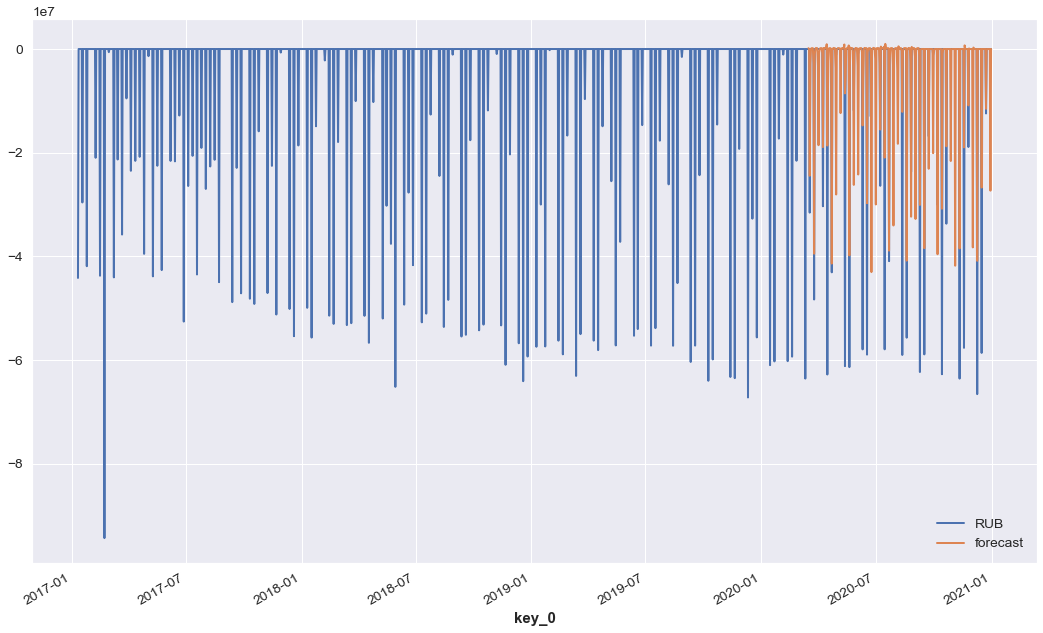

In [169]:
# Отрисовка для LightGBM, тут на глаз видно, что есть вылеты за 0 в положительную сторону, их принудительно обнуляем, т.к. (если правильно понял) у нас транзакции все в одну сторону
series_1d.plot()
prediction1d.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [170]:
fixed_prediction1d = prediction1d.pd_dataframe()
fixed_prediction1d[fixed_prediction1d["RUB"]>0] = 0
mean_absolute_error(val_1d_split.pd_dataframe(), prediction1d.pd_dataframe())

3739531.604263775

In [172]:
mean_absolute_error(val_1d_split.pd_dataframe(), fixed_prediction1d)

3664309.730699355

In [216]:
predict_series_baseline = fixed_prediction1d["RUB"]

In [217]:
val_df = pd.DataFrame()
val_df.index = predict_series_baseline.index
val_df["y"] = train_5_1d#.loc["2020-03-16":]
val_df["yhat"] = predict_series_baseline

<AxesSubplot:xlabel='key_0'>

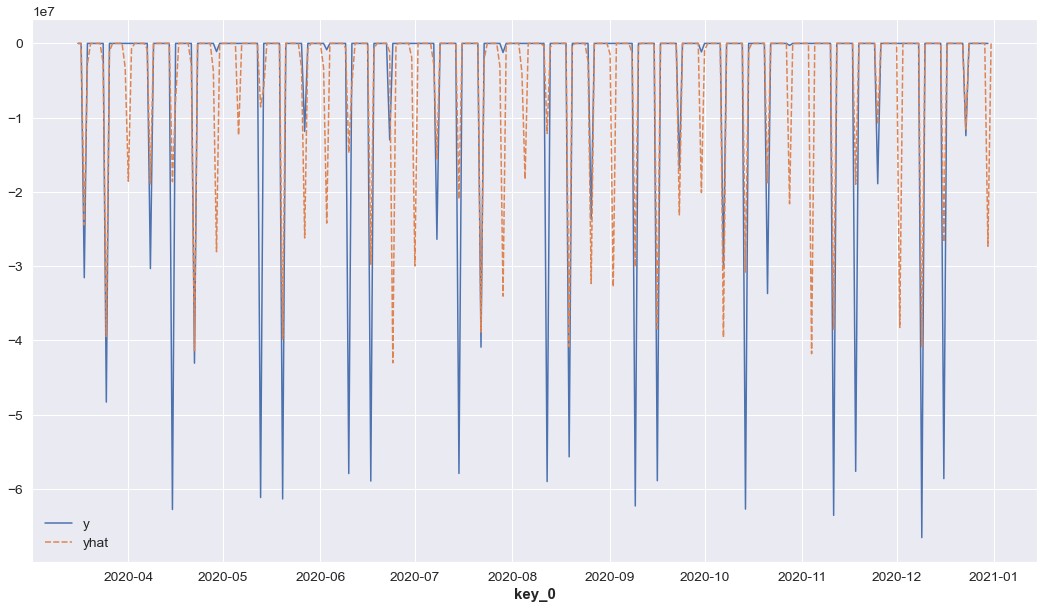

In [218]:
# График валидации для baseline модели
sns.lineplot(data=val_df)

In [ ]:
#################################################################################################################################################################################################################

In [ ]:
# Использование доп. данных в качестве регрессоров

In [ ]:
# best_params

In [232]:
# LightGBMModel(lags=[-1, -7, -7], lags_past_covariates=7 , output_chunk_length=180) # 1998313.7149369963  MAE
# LightGBMModel(lags=[-7, -45, -90], lags_past_covariates=7 , output_chunk_length=180) # 1889233.9345722394
# LightGBMModel(lags=[-5, -45, -90], lags_past_covariates=7, output_chunk_length=180) # 1828684.890515898
model1dcov = LightGBMModel(lags=[-5, -45, -90], lags_past_covariates=7, output_chunk_length=180)
model1dcov.fit(train_1d_split, past_covariates=series_1d_pastcov1.stack(series_1d_pastcov2))
prediction1dcov = model1dcov.predict(len(val_1d_split), past_covariates=series_1d_pastcov1.stack(series_1d_pastcov2))

In [233]:
fixed_prediction1dcov = prediction1dcov.pd_dataframe()
mean_absolute_error(val_1d_split.pd_dataframe(), prediction1dcov.pd_dataframe())

1828684.890515898

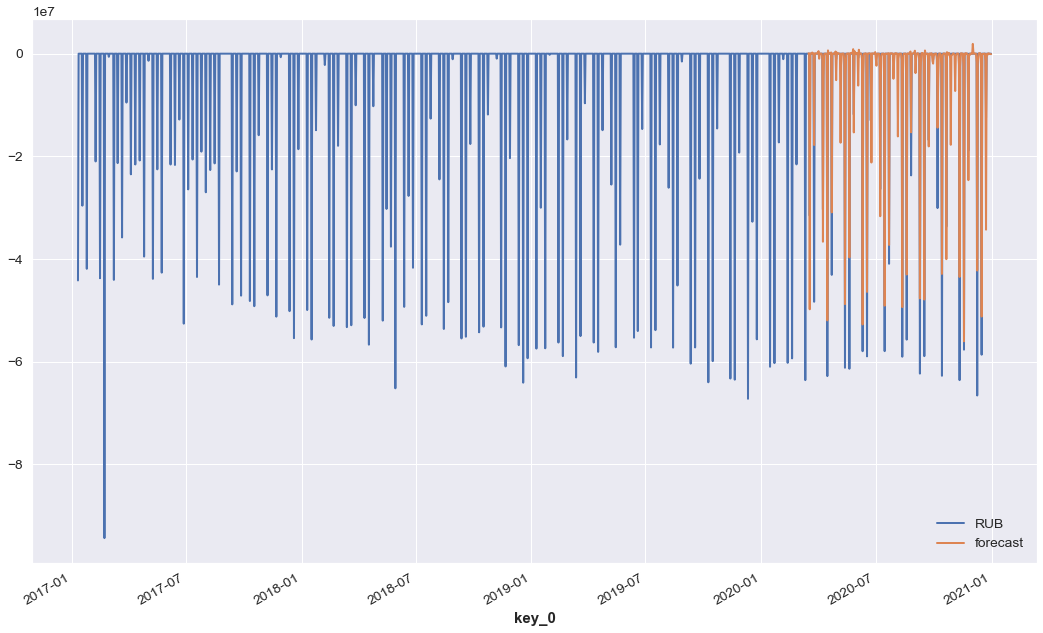

In [234]:
# Отрисовка для LightGBM, тут на глаз видно, что есть вылеты за 0 в положительную сторону, их принудительно обнуляем, т.к. (если правильно понял) у нас транзакции все в одну сторону
series_1d.plot()
prediction1dcov.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [235]:
fixed_prediction1dcov[fixed_prediction1dcov["RUB"]>0] = 0

In [236]:
# MAE для подправленных данных
mean_absolute_error(val_1d_split.pd_dataframe(), fixed_prediction1dcov)

1779833.379297241

In [219]:
predict_series = fixed_prediction1dcov["RUB"]

In [222]:
valcov_df = pd.DataFrame()
valcov_df.index = predict_series.index
valcov_df["y"] = train_5_1d#.loc["2020-03-16":]
valcov_df["yhat"] = predict_series
valcov_df.index.names = ['Date']

In [224]:
valcov_df

,y,yhat
Date,,
2020-03-16,0.000000e+00,0.000000e+00
2020-03-17,0.000000e+00,0.000000e+00
2020-03-18,-3.156127e+07,-4.978321e+07
2020-03-19,0.000000e+00,0.000000e+00
2020-03-20,0.000000e+00,0.000000e+00
...,...,...
2020-12-27,0.000000e+00,0.000000e+00
2020-12-28,0.000000e+00,0.000000e+00
2020-12-29,0.000000e+00,-5.103498e+04


<AxesSubplot:xlabel='Date'>

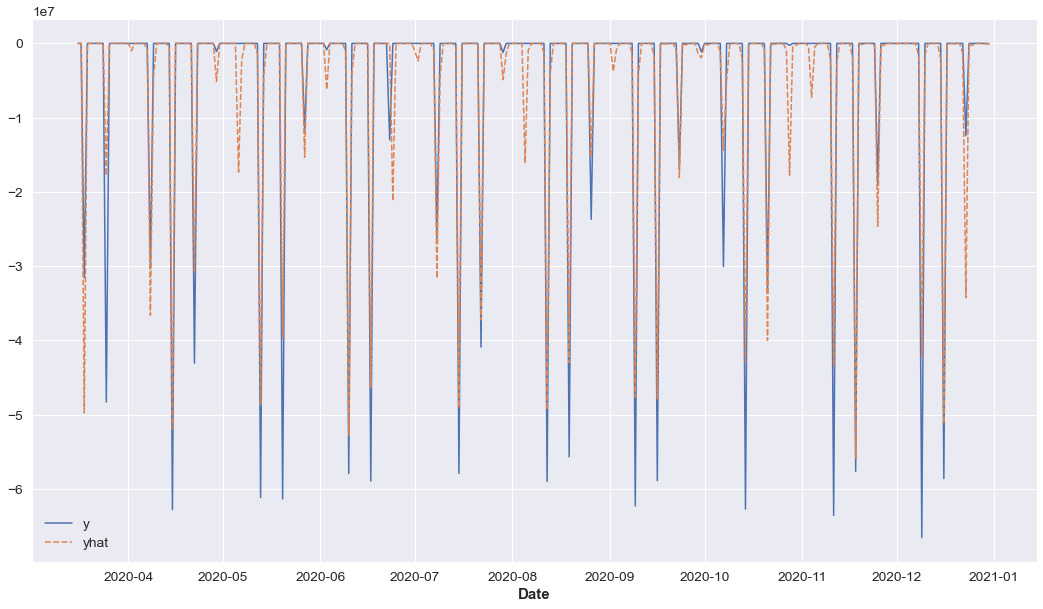

In [223]:
# График валидации для baseline модели
sns.lineplot(data=valcov_df)

In [ ]:
#################################################################################################################################################################################################################

In [ ]:
# Предсказание на первые два квартала 2021 полностью невозможно сделать моделью, т.к. данных не хватило при вышеиспользованных гиперпараметрах

In [ ]:
# В коде ниже:
#    Собираем сначала переобучаем модель на полных данныз
#    Для предикта приходится пересобрать данные для past_covariates, т.к. ранее они были обрезаны
#    Предикт на covariate модели до определенного числа
#    Переобучаем простую модель и делаем предикт за пределы covariate модели
#    Собираем предикты в один временной ряд

In [239]:
# refit на данных до 2021 года
refit_model1dcov = LightGBMModel(lags=[-5, -45, -90], lags_past_covariates=7, output_chunk_length=180)
refit_model1dcov.fit(series_1d, past_covariates=series_1d_pastcov1.stack(series_1d_pastcov2))
#refit_prediction1dcov = refit_model1dcov.predict(len(val_1d_split))

In [286]:
# Данные для предикта
refit_contractor_fixed_prepay = contractor_fixed[(contractor_fixed["Date_reg_prepay"].dt.date>=pd.to_datetime("2017-01-01"))][["Date_reg_prepay", "Sum_paid_VAT"]]
refit_contractor_fixed_prepay.set_index("Date_reg_prepay", inplace=True)
refit_contractor_fixed_prepay = refit_contractor_fixed_prepay.groupby(refit_contractor_fixed_prepay.index).sum()
refit_contractor_fixed_prepay_1d = refit_contractor_fixed_prepay.resample('1D').sum()

D:\Anaconda\envs\Python3712forTS\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [287]:
refit_contractor_fixed_pay = contractor_fixed[(contractor_fixed["Date_reg_fin"].dt.date>=pd.to_datetime("2017-01-01"))][["Date_reg_fin", "Sum_to_pay_with_prepay_VAT"]]
refit_contractor_fixed_pay.set_index("Date_reg_fin", inplace=True)
refit_contractor_fixed_pay = refit_contractor_fixed_pay.groupby(refit_contractor_fixed_pay.index).sum()
refit_contractor_fixed_pay_1d = refit_contractor_fixed_pay.resample('1D').sum()

D:\Anaconda\envs\Python3712forTS\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [288]:
#pd.date_range(start="2021-01-01", end="2021-06-30", freq="1d")

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24',
               '2021-06-25', '2021-06-26', '2021-06-27', '2021-06-28',
               '2021-06-29', '2021-06-30'],
              dtype='datetime64[ns]', length=181, freq='D')

In [289]:
refit_cov_1d = pd.merge(refit_contractor_fixed_pay_1d, refit_contractor_fixed_prepay_1d, how='outer', left_on=refit_contractor_fixed_pay_1d.index, right_on=refit_contractor_fixed_prepay_1d.index).fillna(0)

In [291]:
refit_pastcov1 = TimeSeries.from_dataframe(refit_cov_1d, time_col='key_0', value_cols='Sum_paid_VAT', freq='1d', fill_missing_dates=True)

In [292]:
refit_pastcov2 = TimeSeries.from_dataframe(refit_cov_1d, time_col='key_0', value_cols='Sum_to_pay_with_prepay_VAT', freq='1d', fill_missing_dates=True)

In [295]:
refit_model1dcov_predict = refit_model1dcov.predict(len(pd.date_range(start="2021-01-01", end="2021-04-30", freq="1d")), past_covariates=refit_pastcov1.stack(refit_pastcov2))
#model1dcov.predict(len(val_1d_split), past_covariates=series_1d_pastcov1.stack(series_1d_pastcov2))

In [300]:
df_refit_model1dcov_predict = refit_model1dcov_predict.pd_dataframe()
df_refit_model1dcov_predict[df_refit_model1dcov_predict["RUB"]>0]=0

In [ ]:
#################################################################################################################################################################################################################

In [307]:
refit_model1d = LightGBMModel(lags=[-3, -19, -82], output_chunk_length=180)
refit_model1d.fit(series_1d)
refit_prediction1d = refit_model1d.predict(len(pd.date_range(start="2021-01-01", end="2021-06-30", freq="1d")))

In [308]:
df_refit_prediction1d = refit_prediction1d.pd_dataframe()
df_refit_prediction1d[df_refit_prediction1d["RUB"]>0]=0

In [310]:
df_refit_model1dcov_predict

component,RUB
key_0,
2021-01-01,-2.281039e+05
2021-01-02,-2.934475e+04
2021-01-03,-1.719632e+05
2021-01-04,-2.450485e+05
2021-01-05,0.000000e+00
...,...
2021-04-26,-1.415466e+04
2021-04-27,0.000000e+00
2021-04-28,-1.783538e+06


In [312]:
df_refit_prediction1d["2021-05-01":]

component,RUB
key_0,
2021-05-01,-5.627305e+06
2021-05-02,-9.421460e+05
2021-05-03,-5.454638e+06
2021-05-04,-1.080912e+06
2021-05-05,-5.719453e+06
...,...
2021-06-26,-5.564159e+06
2021-06-27,-1.261909e+06
2021-06-28,-5.575962e+06


In [323]:
train_5_ans = pd.DataFrame()
#train_1_ans["Дата транзакции"] = pd.date_range(start="2021-01-05", end="2021-06-29", freq="7D") # legacy version
train_5_ans["Дата транзакции"] = pd.date_range(start="2021-01-01", end="2021-06-30", freq="1D")
train_5_ans["Сумма в RUB"] = pd.concat([df_refit_model1dcov_predict, df_refit_prediction1d["2021-05-01":]], ignore_index=False).values
train_5_ans["Сумма в RUB"] = train_5_ans["Сумма в RUB"].groupby(train_5_ans["Дата транзакции"].dt.month).cumsum().values
train_5_ans["Месяц"] = train_5_ans["Дата транзакции"].dt.month
train_5_ans["БЕ"] = 5

In [325]:
train_5_ans.to_csv("train_5_ans.csv")

In [272]:
#contractor_fixed[(contractor_fixed["Date_reg_prepay"].dt.year>=2021) & (contractor_fixed["Date_reg_fin"].dt.year>=2021)][["Date_reg_prepay", "Date_reg_fin", "Sum_paid_VAT", "Sum_to_pay_with_prepay_VAT"]]